In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import ast
from tqdm import tqdm
from collections import defaultdict

In [2]:
# install these
#https://pymicro.readthedocs.io/projects/pymicro/en/latest/cookbook/pointset_registration.html
from pymicro.view.vol_utils import compute_affine_transform
#https://pypi.org/project/affine6p/
import affine6p
#https://github.com/jewettaij/superpose3d
from superpose3d import Superpose3D

In [3]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(DIR)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer, \
    create_full_volume, get_structure_colors
from utilities.sqlcontroller import SqlController
animal = 'MD589'
sqlController = SqlController(animal)

CSV_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/foundation_brain_annotations'
csvfile = os.path.join(CSV_PATH, 'MD589_annotation.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations.head()
hand_annotations['vertices'] = hand_annotations['vertices'] \
    .apply(lambda x: x.replace(' ', ','))\
    .apply(lambda x: x.replace('\n',','))\
    .apply(lambda x: x.replace(',]',']'))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ',')).apply(lambda x: x.replace(',,', ','))

hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))
structures = ['DC', 'LC','SC', '5N', '7n']
# SC is the only singular structure
df = hand_annotations[['name', 'section', 'side', 'vertices']].copy()
df = df.loc[df['name'].isin(structures)]
df = df.reset_index()
df = df.sort_values(by=['name', 'section'])
df.head()

Connecting dklab@192.168.1.12:3306


,index,name,section,side,vertices
191,843,5N,150,L,"[[23467.35736638, 13029.96696407], [23371.8771..."
369,1683,5N,151,L,"[[22119.53951512, 14078.59777646], [21969.6072..."
451,2089,5N,152,L,"[[23441.88459431, 13586.7746992], [23299.53025..."
116,489,5N,153,L,"[[22705.00744451, 13825.99679013], [22571.2393..."
49,198,5N,154,L,"[[22703.58621367, 14048.8018496], [22552.64526..."


In [4]:
# these are the 5 structures Beth suggested for getting
# enough that were spread out.
structures = ['DC', 'LC','SC', '5N', '7n']
centers = {}
section_structure_vertices = defaultdict(dict)
SC = df.loc[(df['name'] == "SC")]
first_section = SC['section'].min()
last_section = SC['section'].max()
midsection = int(round(((last_section - first_section) / 2) + first_section))
point_array = SC['vertices'].loc[SC['section'] == midsection].values
section_structure_vertices[midsection]['SC'] = point_array[0]
cx, cy = np.mean(point_array[0], axis=0)    
centers['SC'] = [int(round(cx)), int(round(cy)), int(round(midsection))]

structures.remove('SC')
for structure in structures:
    df_tmp = df.loc[(df['name'] == structure) & (df['side'] == "L")]
    first_section = df_tmp['section'].min()
    last_section = df_tmp['section'].max()
    midsection = int(round(((last_section - first_section) / 2) + first_section))
    structure_name = structure + "_L"
    point_array = df_tmp['vertices'].loc[df_tmp['section'] == midsection].values
    section_structure_vertices[midsection][structure_name] = point_array[0]
    cx, cy = np.mean(point_array[0], axis=0)    
    centers[structure_name] = [int(round(cx)), int(round(cy)), int(round(midsection))]
    
    df_tmp = df.loc[(df['name'] == structure) & (df['side'] == "R")]
    first_section = df_tmp['section'].min()
    last_section = df_tmp['section'].max()
    midsection = int(round(((last_section - first_section) / 2) + first_section))
    structure_name = structure + "_R"
    point_array = df_tmp['vertices'].loc[df_tmp['section'] == midsection].values
    section_structure_vertices[midsection][structure_name] = point_array[0]
    cx, cy = np.mean(point_array[0], axis=0)    
    centers[structure_name] = [int(round(cx)), int(round(cy)), int(round(midsection))]


In [5]:
centers

{'SC': [24226, 6401, 220],
 'DC_L': [24482, 11985, 134],
 'DC_R': [20424, 11736, 330],
 'LC_L': [25290, 11750, 180],
 'LC_R': [24894, 12079, 268],
 '5N_L': [23790, 13025, 160],
 '5N_R': [20805, 14163, 298],
 '7n_L': [20988, 18405, 177],
 '7n_R': [24554, 13911, 284]}

In [6]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
thickness = 1
colors = {}
colors['SC'] = (255,0,255)

colors['DC_L'] = (0,0,0)
colors['LC_L'] = (255,0,0)
colors['SC_L'] = (255,0,255)
colors['5N_L'] = (0,255,255)
colors['7n_L'] = (100,10,255)
colors['DC_R'] = (0,0,0)
colors['LC_R'] = (255,0,0)
colors['SC_R'] = (255,0,255)
colors['5N_R'] = (0,255,255)
colors['7n_R'] = (100,10,255)
# create a fake random distance away from the original structures
rand_offset = np.random.randint(75,150)
offsets = {}
section_images = {}
points = {}
SCALE = 32
PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1'
thumbnail_dir = os.path.join(PATH, 'thumbnail')
files = sorted(os.listdir(thumbnail_dir))
for file_name in tqdm(files):
    filepath = os.path.join(thumbnail_dir, file_name)
    img = cv2.imread(filepath)
    section = int(file_name.split('.')[0])
    
    for structure in section_structure_vertices[section]:
        pts = section_structure_vertices[section][structure]
        points = np.array(pts, dtype=np.int32)        
        points = points // SCALE
        
        points_diff = np.rint(points + rand_offset)
        points_diff = points_diff.astype(np.int32)
        cxoff, cyoff = np.mean(points_diff, axis=0)
        offsets[structure] = [int(round(cxoff*SCALE)), int(round(cyoff*SCALE)), section]
        
        cv2.polylines(img, [points_diff], isClosed=True, color=(0,0,0), thickness=5)
        cx = centers[structure][0] // SCALE
        cy = centers[structure][1] // SCALE
        
        cv2.circle(img, (cx,cy), 10, (0,0,0), -1)
            
        cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=2)
        cv2.putText(img, structure, (cx,cy), font,
                    fontScale, colors[structure], thickness, cv2.LINE_AA)
            
    section_images[section] = img

100%|██████████| 448/448 [00:04<00:00, 108.19it/s]


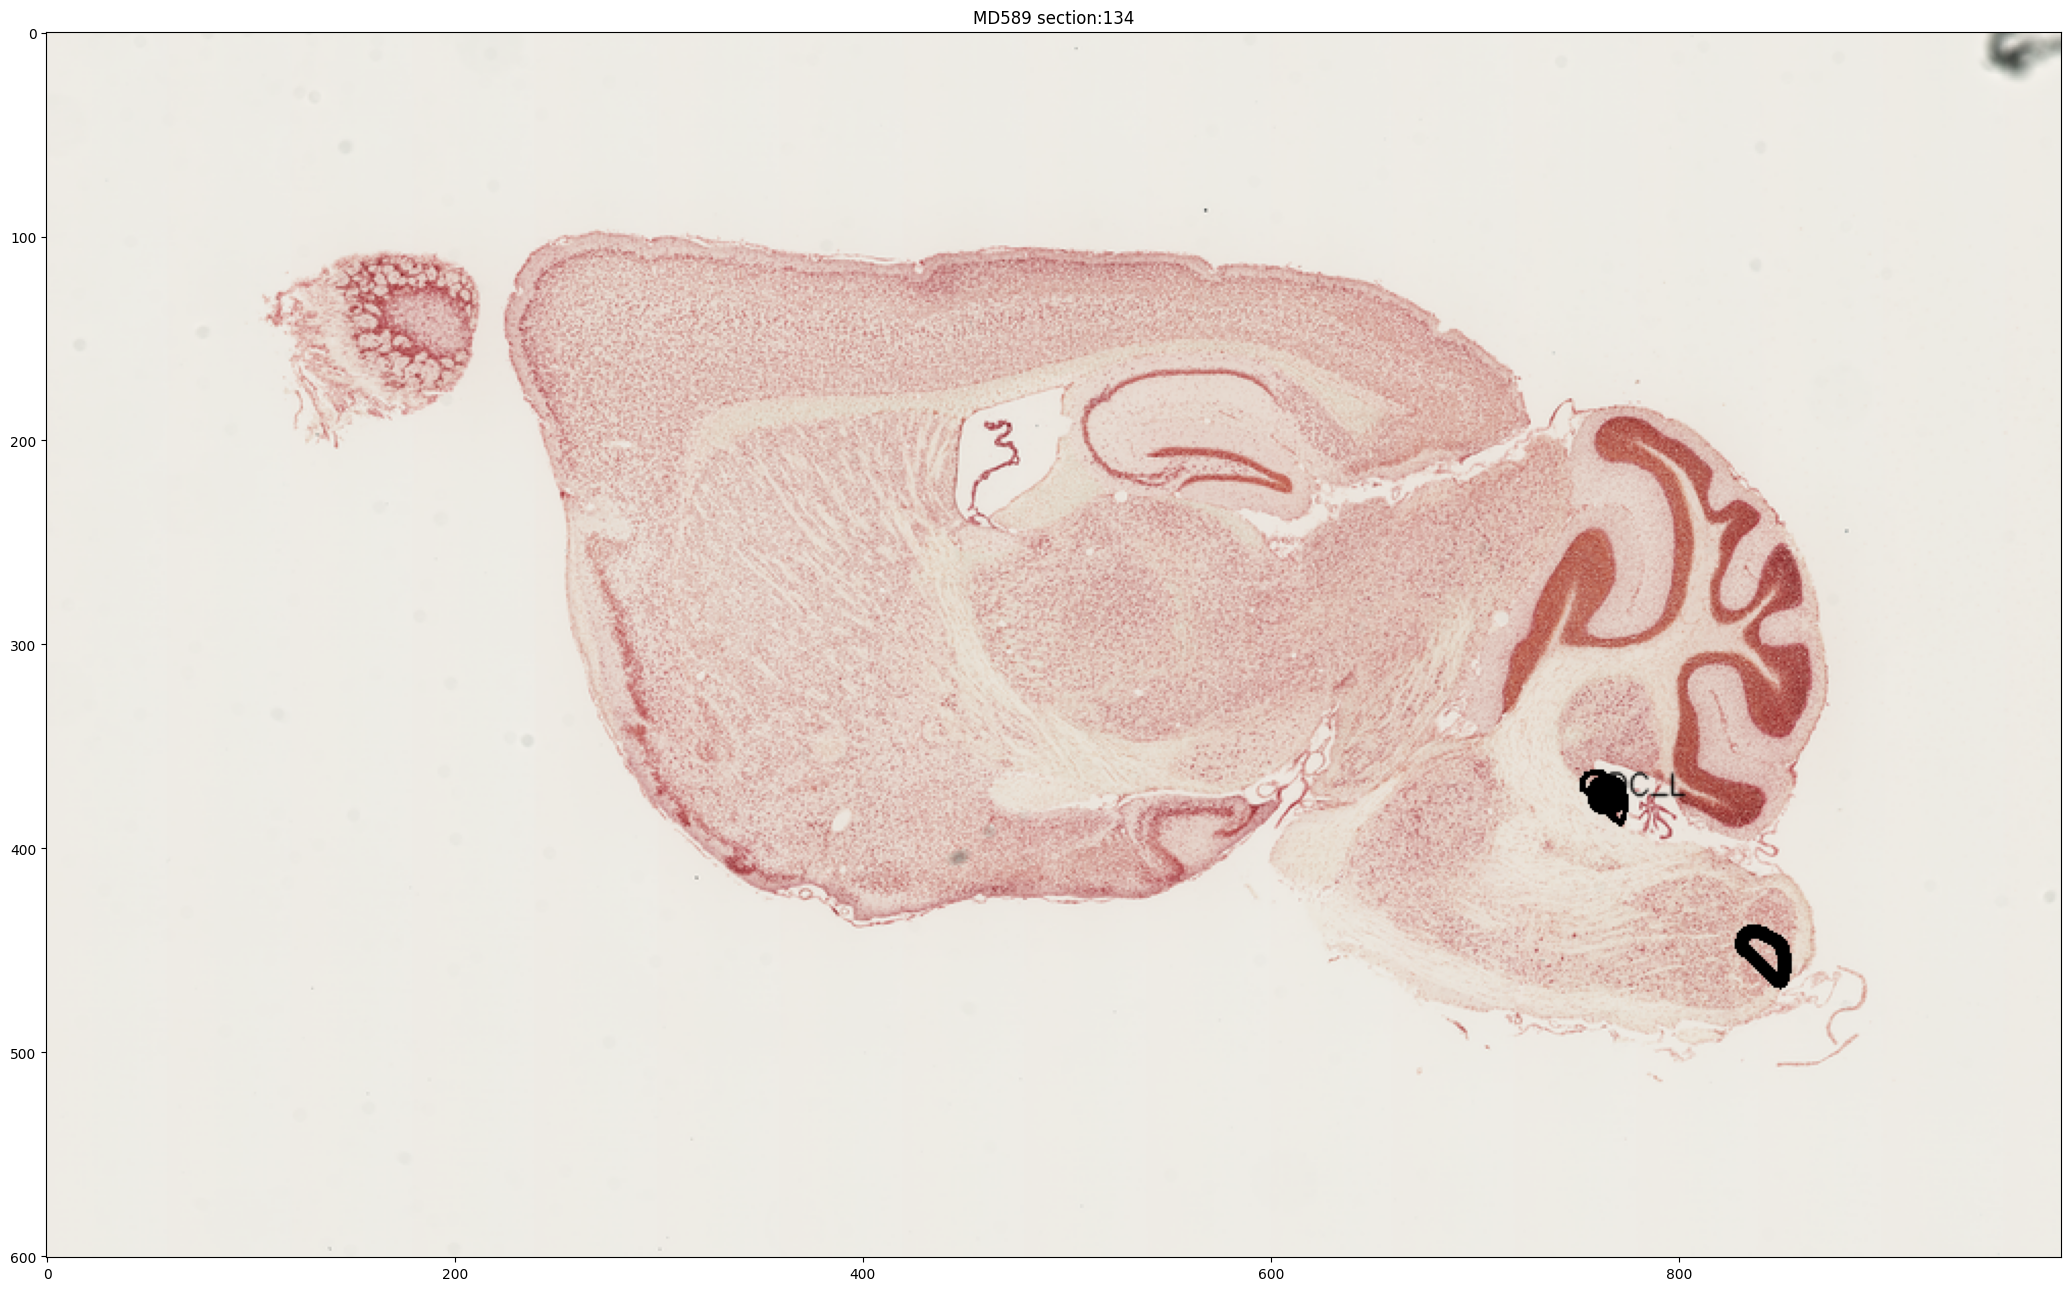

In [28]:
# this shows the real structure, it's center of mass and a fake offsetted structure
structure_midpoints = [134,160,177,180,220,268,284,298,330]
section = structure_midpoints[0]
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(section_images[section], cmap="cool")
plt.title('{} section:{}'.format(animal, section))
plt.show()

In [8]:
offsets

{'DC_L': [26964, 14467, 134],
 '5N_L': [26271, 15506, 160],
 '7n_L': [23470, 20887, 177],
 'LC_L': [27770, 14229, 180],
 'SC': [26705, 8880, 220],
 'LC_R': [27375, 14561, 268],
 '7n_R': [27034, 16388, 284],
 '5N_R': [23286, 16640, 298],
 'DC_R': [22900, 14215, 330]}

In [9]:
origin = np.array(list(centers.values()), dtype=np.float32)
fitted = np.array(list(offsets.values()), dtype=np.float32)
# create a fake structure with a center of mass at:
other_structure = (25000,15000,200)
print(origin.shape, fitted.shape, other_structure)

(9, 3) (9, 3) (25000, 15000, 200)


In [10]:
origin_centroid = np.mean(origin, axis=0)
fitted_centroid = np.mean(fitted, axis=0)
print(origin_centroid, fitted_centroid, other_structure)

[23272.555   12606.111     227.88889] [25752.777   15085.889     227.88889] (25000, 15000, 200)


In [11]:
import affine6p
trans = affine6p.estimate(origin, fitted)
translated = trans.transform(other_structure)
print('translated',translated)
rotated = trans.rotate(other_structure)
print('rotated',rotated)
both = trans.rotate(translated)
print('both',both)

translated [25730.89825758733, 12184.858835234118]
rotated [3955.511410012136, -37537.99379513804]
both [4778.727386834258, -37899.01603405886]


In [18]:
RMSD, R, T, c = Superpose3D(origin, fitted)

In [24]:
print(other_structure)
origin_centroid + np.dot(R, other_structure - fitted_centroid)

(25000, 15000, 200)


array([23340.99434766, 13355.80261894,   317.92979032])

In [15]:
# compute the affine transform from the point set
translation, transformation = compute_affine_transform(origin, fitted)
invt = np.linalg.inv(transformation)
offset = -np.dot(invt, translation)
print(other_structure, origin_centroid + np.dot(transformation, other_structure - fitted_centroid))

(25000, 15000, 200) [23612.06562033 11737.36498269   235.02158154]


point 0 will move to (24387.8, 9138.1, 208.1) to be compared with (24226.0, 6401.0, 220.0)
point 1 will move to (23670.8, 10287.5, 218.8) to be compared with (24482.0, 11985.0, 134.0)
point 2 will move to (21010.7, 12116.9, 259.0) to be compared with (20424.0, 11736.0, 330.0)
point 3 will move to (24036.5, 10565.6, 200.9) to be compared with (25290.0, 11750.0, 180.0)
point 4 will move to (26347.0, 11194.3, 208.5) to be compared with (24894.0, 12079.0, 268.0)
point 5 will move to (23075.5, 13678.7, 210.6) to be compared with (23790.0, 13025.0, 160.0)
point 6 will move to (22046.4, 14569.7, 217.7) to be compared with (20805.0, 14163.0, 298.0)
point 7 will move to (21982.3, 15579.0, 262.1) to be compared with (20988.0, 18405.0, 177.0)
point 8 will move to (22896.0, 16325.2, 265.2) to be compared with (24554.0, 13911.0, 284.0)


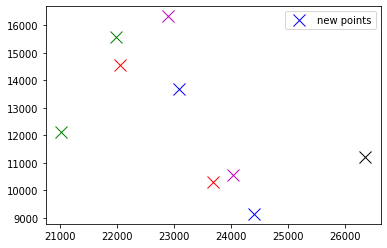

In [16]:
colors = 'brgmkbrgmk'
new_points = np.empty_like(origin)
for i in range(len(origin)):
    new_points[i] = origin_centroid + np.dot(transformation, fitted[i] - fitted_centroid)
    print('point %d will move to (%3.1f, %3.1f, %3.1f) to be compared with (%3.1f, %3.1f, %3.1f)' % (
    i, new_points[i, 0], new_points[i, 1], new_points[i, 2], origin[i, 0], origin[i, 1], origin[i, 2]))
    plt.plot(new_points[i, 0], new_points[i, 1], 'x', color=colors[i], markersize=12,
             label='new points' if i == 0 else '')
plt.legend(numpoints=1)
plt.show()


In [17]:
new_points

array([[24387.848  ,  9138.091  ,   208.12994],
       [23670.795  , 10287.484  ,   218.84799],
       [21010.654  , 12116.884  ,   259.0329 ],
       [24036.475  , 10565.637  ,   200.9226 ],
       [26346.98   , 11194.256  ,   208.52916],
       [23075.535  , 13678.749  ,   210.5578 ],
       [22046.395  , 14569.697  ,   217.68054],
       [21982.297  , 15579.027  ,   262.12006],
       [22896.014  , 16325.177  ,   265.17892]], dtype=float32)